In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [5]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/not_hand/*.png")

In [6]:
len(hand_files)

3244

In [7]:
len(not_hand_files)

3244

# Camera Image

## Preprocessing

In [8]:
from vision_control.camera import *

In [12]:
img = CameraImage(file_path=hand_files[50])

In [13]:
img.preprocess()

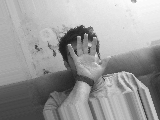

In [14]:
img

## Building the dataset

In [9]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True,full = False) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True,full = False) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|████████████| 3244/3244 [00:06<00:00, 536.11it/s]


In [10]:
images = CameraImages(camera_images=all_img)

In [17]:
X = images.build_X()

100%|██████████████████████████████████████| 6488/6488 [03:15<00:00, 33.15it/s]


In [18]:
X.shape

(6488, 19200)

In [11]:
y = images.build_y()

In [12]:
y.shape

(6488, 1)

# Train a simple model

In [13]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


## Creating the MLP

In [117]:
model = Sequential()
model.add(Dense(512,input_dim = X.shape[1],activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
optimizer = Adam(lr=0.002)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
from sklearn.model_selection import train_test_split

In [100]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [118]:
model.fit(X_train,y_train,epochs=50,verbose = 2,batch_size=32,shuffle=True,validation_data=(X_test,y_test))

Train on 4866 samples, validate on 1622 samples
Epoch 1/50
49s - loss: 0.9721 - acc: 0.5099 - val_loss: 0.6898 - val_acc: 0.6178
Epoch 2/50
45s - loss: 0.6963 - acc: 0.5306 - val_loss: 0.6914 - val_acc: 0.4994
Epoch 3/50
44s - loss: 0.6977 - acc: 0.5308 - val_loss: 0.6886 - val_acc: 0.5247
Epoch 4/50
45s - loss: 0.6918 - acc: 0.5485 - val_loss: 0.6890 - val_acc: 0.5123
Epoch 5/50
47s - loss: 0.6879 - acc: 0.5454 - val_loss: 0.6827 - val_acc: 0.5197
Epoch 6/50
48s - loss: 0.6763 - acc: 0.5853 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 7/50
48s - loss: 0.6762 - acc: 0.5824 - val_loss: 0.6800 - val_acc: 0.5216
Epoch 8/50
48s - loss: 0.6708 - acc: 0.6021 - val_loss: 0.6828 - val_acc: 0.5456
Epoch 9/50
46s - loss: 0.6702 - acc: 0.5892 - val_loss: 0.6846 - val_acc: 0.5216
Epoch 10/50
44s - loss: 0.6664 - acc: 0.6083 - val_loss: 0.6733 - val_acc: 0.5438
Epoch 11/50
45s - loss: 0.6635 - acc: 0.6147 - val_loss: 0.6962 - val_acc: 0.5000
Epoch 12/50
52s - loss: 0.6531 - acc: 0.6235 - val_loss: 0.

## Live test

In [183]:
test = CameraImage(capture = True)

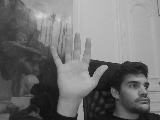

In [184]:
test

In [185]:
test.predict(model,full = True,flatten = False)

0.69981021

In [127]:
selection = np.random.randint(1,1000,10)

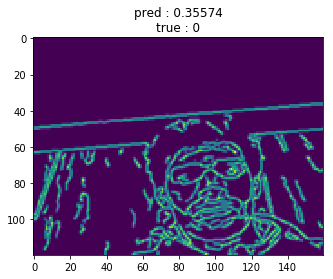

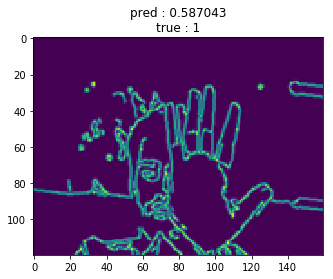

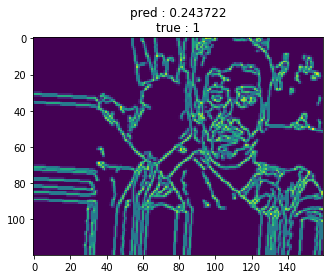

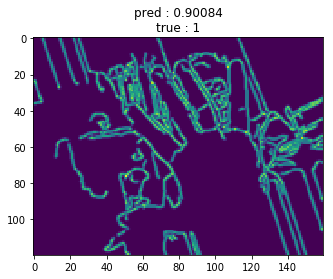

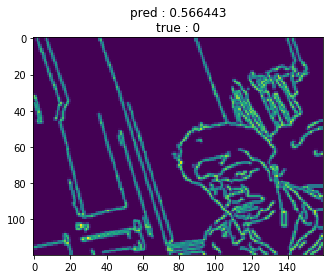

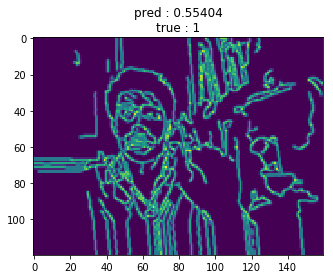

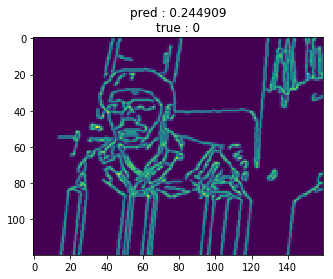

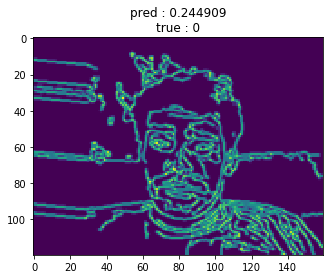

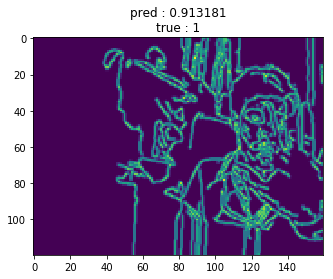

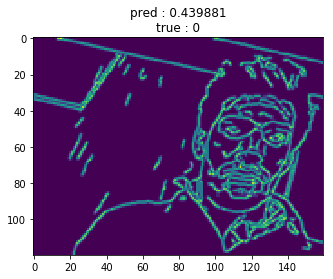

In [135]:
for i in selection:
    x = X_test[i]
    y = y_test[i][0]
    
    
    pred = model.predict(np.expand_dims(x,axis = 0))[0][0]
    plt.imshow(x.reshape((120,160)))
    plt.title("pred : {0:3g}\ntrue : {1}".format(pred,y))
    plt.show()

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

## Saving the model

In [170]:
model.save("C:/git/computer-vision-control/models/model_cnn.h5")

In [171]:
with open("C:/git/computer-vision-control/models/model_cnn.json", "w") as json_file:
    json_file.write(model.to_json())

## Test reloading the model

In [2]:
%%time
from keras.models import model_from_json

Wall time: 0 ns


In [10]:
model = model_from_json(open("C:/git/computer-vision-control/models/model_mlp.json","r").read())
model.load_weights("C:/git/computer-vision-control/models/model_mlp.h5")

# Train a more complex model : CNN

## Building a dataset not flattened

In [15]:
X = images.build_X(flatten=False)
X.shape

100%|██████████████████████████████████████| 6488/6488 [03:16<00:00, 32.94it/s]


(6488, 120, 160, 1)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

## Creating the model

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(120,160,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,verbose = 1)

Train on 4866 samples, validate on 1622 samples
Epoch 1/10
4866/4866 [==============================] - ETA: 421s - loss: 0.6948 - acc: 0.500 - ETA: 338s - loss: 0.8681 - acc: 0.546 - ETA: 307s - loss: 1.1312 - acc: 0.541 - ETA: 292s - loss: 1.1176 - acc: 0.523 - ETA: 283s - loss: 1.0314 - acc: 0.537 - ETA: 275s - loss: 0.9696 - acc: 0.541 - ETA: 269s - loss: 0.9325 - acc: 0.526 - ETA: 264s - loss: 0.9044 - acc: 0.511 - ETA: 260s - loss: 0.8813 - acc: 0.513 - ETA: 257s - loss: 0.8626 - acc: 0.521 - ETA: 254s - loss: 0.8475 - acc: 0.508 - ETA: 251s - loss: 0.8346 - acc: 0.518 - ETA: 248s - loss: 0.8236 - acc: 0.519 - ETA: 245s - loss: 0.8142 - acc: 0.524 - ETA: 242s - loss: 0.8061 - acc: 0.522 - ETA: 240s - loss: 0.7991 - acc: 0.523 - ETA: 238s - loss: 0.7928 - acc: 0.523 - ETA: 235s - loss: 0.7872 - acc: 0.520 - ETA: 233s - loss: 0.7821 - acc: 0.524 - ETA: 231s - loss: 0.7774 - acc: 0.525 - ETA: 229s - loss: 0.7733 - acc: 0.526 - ETA: 227s - loss: 0.7692 - acc: 0.534 - ETA: 225s - loss

4866/4866 [==============================] - ETA: 255s - loss: 0.5780 - acc: 0.656 - ETA: 257s - loss: 0.5622 - acc: 0.703 - ETA: 255s - loss: 0.5847 - acc: 0.697 - ETA: 252s - loss: 0.5872 - acc: 0.703 - ETA: 250s - loss: 0.5560 - acc: 0.725 - ETA: 250s - loss: 0.5385 - acc: 0.750 - ETA: 249s - loss: 0.5465 - acc: 0.745 - ETA: 248s - loss: 0.5552 - acc: 0.738 - ETA: 247s - loss: 0.5530 - acc: 0.739 - ETA: 246s - loss: 0.5549 - acc: 0.725 - ETA: 244s - loss: 0.5435 - acc: 0.733 - ETA: 242s - loss: 0.5514 - acc: 0.726 - ETA: 240s - loss: 0.5410 - acc: 0.735 - ETA: 238s - loss: 0.5398 - acc: 0.732 - ETA: 236s - loss: 0.5460 - acc: 0.725 - ETA: 234s - loss: 0.5562 - acc: 0.712 - ETA: 232s - loss: 0.5528 - acc: 0.709 - ETA: 231s - loss: 0.5523 - acc: 0.708 - ETA: 229s - loss: 0.5579 - acc: 0.707 - ETA: 227s - loss: 0.5550 - acc: 0.714 - ETA: 225s - loss: 0.5563 - acc: 0.711 - ETA: 223s - loss: 0.5552 - acc: 0.711 - ETA: 221s - loss: 0.5541 - acc: 0.710 - ETA: 220s - loss: 0.5516 - acc: 0.7

4866/4866 [==============================] - ETA: 255s - loss: 0.4840 - acc: 0.750 - ETA: 255s - loss: 0.4588 - acc: 0.781 - ETA: 253s - loss: 0.4999 - acc: 0.770 - ETA: 251s - loss: 0.5017 - acc: 0.757 - ETA: 251s - loss: 0.4840 - acc: 0.756 - ETA: 249s - loss: 0.4961 - acc: 0.739 - ETA: 247s - loss: 0.4824 - acc: 0.750 - ETA: 245s - loss: 0.4799 - acc: 0.753 - ETA: 243s - loss: 0.4798 - acc: 0.763 - ETA: 241s - loss: 0.4657 - acc: 0.771 - ETA: 240s - loss: 0.4755 - acc: 0.767 - ETA: 238s - loss: 0.4695 - acc: 0.773 - ETA: 236s - loss: 0.4675 - acc: 0.783 - ETA: 234s - loss: 0.4660 - acc: 0.779 - ETA: 232s - loss: 0.4647 - acc: 0.783 - ETA: 231s - loss: 0.4542 - acc: 0.789 - ETA: 229s - loss: 0.4598 - acc: 0.783 - ETA: 228s - loss: 0.4616 - acc: 0.779 - ETA: 226s - loss: 0.4576 - acc: 0.782 - ETA: 225s - loss: 0.4614 - acc: 0.782 - ETA: 223s - loss: 0.4551 - acc: 0.782 - ETA: 221s - loss: 0.4521 - acc: 0.784 - ETA: 219s - loss: 0.4474 - acc: 0.786 - ETA: 218s - loss: 0.4466 - acc: 0.7

4866/4866 [==============================] - ETA: 256s - loss: 0.4617 - acc: 0.843 - ETA: 253s - loss: 0.4099 - acc: 0.843 - ETA: 253s - loss: 0.3796 - acc: 0.843 - ETA: 250s - loss: 0.3911 - acc: 0.828 - ETA: 249s - loss: 0.4184 - acc: 0.818 - ETA: 247s - loss: 0.4064 - acc: 0.822 - ETA: 245s - loss: 0.3893 - acc: 0.834 - ETA: 243s - loss: 0.4113 - acc: 0.824 - ETA: 242s - loss: 0.4071 - acc: 0.833 - ETA: 240s - loss: 0.3921 - acc: 0.840 - ETA: 238s - loss: 0.3800 - acc: 0.843 - ETA: 236s - loss: 0.3796 - acc: 0.843 - ETA: 234s - loss: 0.3899 - acc: 0.841 - ETA: 233s - loss: 0.3845 - acc: 0.846 - ETA: 231s - loss: 0.3795 - acc: 0.847 - ETA: 229s - loss: 0.3676 - acc: 0.853 - ETA: 228s - loss: 0.3634 - acc: 0.858 - ETA: 226s - loss: 0.3896 - acc: 0.849 - ETA: 224s - loss: 0.3849 - acc: 0.848 - ETA: 223s - loss: 0.3878 - acc: 0.846 - ETA: 221s - loss: 0.3860 - acc: 0.848 - ETA: 219s - loss: 0.3898 - acc: 0.840 - ETA: 218s - loss: 0.3957 - acc: 0.837 - ETA: 217s - loss: 0.4040 - acc: 0.8

4866/4866 [==============================] - ETA: 255s - loss: 0.2638 - acc: 0.937 - ETA: 254s - loss: 0.2977 - acc: 0.906 - ETA: 252s - loss: 0.3171 - acc: 0.885 - ETA: 250s - loss: 0.2949 - acc: 0.890 - ETA: 249s - loss: 0.3175 - acc: 0.881 - ETA: 248s - loss: 0.2977 - acc: 0.895 - ETA: 246s - loss: 0.2957 - acc: 0.897 - ETA: 245s - loss: 0.2884 - acc: 0.902 - ETA: 243s - loss: 0.2930 - acc: 0.895 - ETA: 241s - loss: 0.2989 - acc: 0.890 - ETA: 240s - loss: 0.3029 - acc: 0.889 - ETA: 238s - loss: 0.2961 - acc: 0.888 - ETA: 237s - loss: 0.3034 - acc: 0.884 - ETA: 236s - loss: 0.3034 - acc: 0.883 - ETA: 234s - loss: 0.2958 - acc: 0.883 - ETA: 232s - loss: 0.2944 - acc: 0.882 - ETA: 230s - loss: 0.2967 - acc: 0.884 - ETA: 228s - loss: 0.2946 - acc: 0.881 - ETA: 227s - loss: 0.2869 - acc: 0.884 - ETA: 225s - loss: 0.2849 - acc: 0.884 - ETA: 223s - loss: 0.2835 - acc: 0.885 - ETA: 221s - loss: 0.2803 - acc: 0.887 - ETA: 219s - loss: 0.2774 - acc: 0.888 - ETA: 218s - loss: 0.2775 - acc: 0.8

4866/4866 [==============================] - ETA: 261s - loss: 0.1661 - acc: 0.937 - ETA: 257s - loss: 0.1783 - acc: 0.921 - ETA: 254s - loss: 0.2294 - acc: 0.885 - ETA: 251s - loss: 0.2342 - acc: 0.882 - ETA: 249s - loss: 0.2777 - acc: 0.875 - ETA: 247s - loss: 0.2820 - acc: 0.875 - ETA: 245s - loss: 0.2935 - acc: 0.866 - ETA: 244s - loss: 0.2981 - acc: 0.859 - ETA: 242s - loss: 0.2904 - acc: 0.861 - ETA: 241s - loss: 0.2855 - acc: 0.859 - ETA: 239s - loss: 0.2878 - acc: 0.858 - ETA: 237s - loss: 0.2758 - acc: 0.867 - ETA: 237s - loss: 0.2882 - acc: 0.867 - ETA: 235s - loss: 0.2845 - acc: 0.868 - ETA: 233s - loss: 0.2835 - acc: 0.868 - ETA: 232s - loss: 0.2751 - acc: 0.875 - ETA: 230s - loss: 0.2719 - acc: 0.880 - ETA: 228s - loss: 0.2715 - acc: 0.878 - ETA: 226s - loss: 0.2671 - acc: 0.881 - ETA: 224s - loss: 0.2679 - acc: 0.882 - ETA: 223s - loss: 0.2817 - acc: 0.878 - ETA: 221s - loss: 0.2776 - acc: 0.879 - ETA: 219s - loss: 0.2727 - acc: 0.881 - ETA: 217s - loss: 0.2698 - acc: 0.8

4866/4866 [==============================] - ETA: 254s - loss: 0.1185 - acc: 0.968 - ETA: 251s - loss: 0.1406 - acc: 0.953 - ETA: 250s - loss: 0.1522 - acc: 0.937 - ETA: 249s - loss: 0.1666 - acc: 0.937 - ETA: 247s - loss: 0.1741 - acc: 0.925 - ETA: 246s - loss: 0.1657 - acc: 0.932 - ETA: 244s - loss: 0.1513 - acc: 0.942 - ETA: 243s - loss: 0.1686 - acc: 0.929 - ETA: 241s - loss: 0.1818 - acc: 0.923 - ETA: 240s - loss: 0.2058 - acc: 0.915 - ETA: 238s - loss: 0.1968 - acc: 0.920 - ETA: 236s - loss: 0.1977 - acc: 0.919 - ETA: 234s - loss: 0.1919 - acc: 0.923 - ETA: 233s - loss: 0.1882 - acc: 0.924 - ETA: 231s - loss: 0.1878 - acc: 0.925 - ETA: 229s - loss: 0.1848 - acc: 0.923 - ETA: 228s - loss: 0.1886 - acc: 0.926 - ETA: 226s - loss: 0.1870 - acc: 0.925 - ETA: 224s - loss: 0.1889 - acc: 0.926 - ETA: 223s - loss: 0.1874 - acc: 0.928 - ETA: 221s - loss: 0.1850 - acc: 0.930 - ETA: 219s - loss: 0.1843 - acc: 0.930 - ETA: 217s - loss: 0.1828 - acc: 0.929 - ETA: 216s - loss: 0.1839 - acc: 0.9

4866/4866 [==============================] - ETA: 255s - loss: 0.1109 - acc: 1.000 - ETA: 254s - loss: 0.1050 - acc: 1.000 - ETA: 256s - loss: 0.1115 - acc: 0.989 - ETA: 254s - loss: 0.1259 - acc: 0.976 - ETA: 252s - loss: 0.2341 - acc: 0.931 - ETA: 249s - loss: 0.2229 - acc: 0.937 - ETA: 247s - loss: 0.2033 - acc: 0.946 - ETA: 246s - loss: 0.1927 - acc: 0.945 - ETA: 243s - loss: 0.1862 - acc: 0.944 - ETA: 243s - loss: 0.1811 - acc: 0.943 - ETA: 240s - loss: 0.1730 - acc: 0.946 - ETA: 239s - loss: 0.1703 - acc: 0.942 - ETA: 236s - loss: 0.1701 - acc: 0.942 - ETA: 234s - loss: 0.1785 - acc: 0.935 - ETA: 233s - loss: 0.1755 - acc: 0.935 - ETA: 231s - loss: 0.1743 - acc: 0.935 - ETA: 229s - loss: 0.1734 - acc: 0.935 - ETA: 228s - loss: 0.1714 - acc: 0.934 - ETA: 226s - loss: 0.1724 - acc: 0.934 - ETA: 225s - loss: 0.1782 - acc: 0.932 - ETA: 223s - loss: 0.1788 - acc: 0.931 - ETA: 221s - loss: 0.1789 - acc: 0.931 - ETA: 220s - loss: 0.1748 - acc: 0.934 - ETA: 218s - loss: 0.1727 - acc: 0.9

4866/4866 [==============================] - ETA: 254s - loss: 0.0448 - acc: 1.000 - ETA: 255s - loss: 0.1075 - acc: 0.953 - ETA: 253s - loss: 0.0945 - acc: 0.968 - ETA: 250s - loss: 0.1047 - acc: 0.960 - ETA: 248s - loss: 0.1176 - acc: 0.950 - ETA: 247s - loss: 0.1254 - acc: 0.937 - ETA: 245s - loss: 0.1475 - acc: 0.933 - ETA: 244s - loss: 0.1388 - acc: 0.937 - ETA: 242s - loss: 0.1323 - acc: 0.941 - ETA: 240s - loss: 0.1251 - acc: 0.943 - ETA: 239s - loss: 0.1219 - acc: 0.946 - ETA: 237s - loss: 0.1202 - acc: 0.947 - ETA: 235s - loss: 0.1162 - acc: 0.951 - ETA: 233s - loss: 0.1295 - acc: 0.950 - ETA: 232s - loss: 0.1464 - acc: 0.943 - ETA: 230s - loss: 0.1399 - acc: 0.945 - ETA: 228s - loss: 0.1352 - acc: 0.948 - ETA: 226s - loss: 0.1336 - acc: 0.947 - ETA: 224s - loss: 0.1306 - acc: 0.949 - ETA: 223s - loss: 0.1313 - acc: 0.948 - ETA: 221s - loss: 0.1313 - acc: 0.947 - ETA: 219s - loss: 0.1300 - acc: 0.948 - ETA: 218s - loss: 0.1285 - acc: 0.949 - ETA: 216s - loss: 0.1300 - acc: 0.9

4866/4866 [==============================] - ETA: 253s - loss: 0.1612 - acc: 0.937 - ETA: 250s - loss: 0.1185 - acc: 0.968 - ETA: 250s - loss: 0.2623 - acc: 0.916 - ETA: 251s - loss: 0.2776 - acc: 0.890 - ETA: 249s - loss: 0.2362 - acc: 0.912 - ETA: 247s - loss: 0.2163 - acc: 0.916 - ETA: 245s - loss: 0.1954 - acc: 0.928 - ETA: 243s - loss: 0.1861 - acc: 0.929 - ETA: 241s - loss: 0.2028 - acc: 0.920 - ETA: 239s - loss: 0.1938 - acc: 0.921 - ETA: 238s - loss: 0.1875 - acc: 0.926 - ETA: 236s - loss: 0.1881 - acc: 0.927 - ETA: 234s - loss: 0.1804 - acc: 0.930 - ETA: 233s - loss: 0.1738 - acc: 0.935 - ETA: 232s - loss: 0.1705 - acc: 0.933 - ETA: 230s - loss: 0.1713 - acc: 0.931 - ETA: 228s - loss: 0.1767 - acc: 0.928 - ETA: 227s - loss: 0.1727 - acc: 0.928 - ETA: 225s - loss: 0.1677 - acc: 0.932 - ETA: 223s - loss: 0.1689 - acc: 0.931 - ETA: 222s - loss: 0.1671 - acc: 0.933 - ETA: 220s - loss: 0.1644 - acc: 0.933 - ETA: 218s - loss: 0.1641 - acc: 0.930 - ETA: 216s - loss: 0.1613 - acc: 0.9

In [169]:
test.predict(model,flatten = False)

0.51472992

# Image Data Generator fit

https://keras.io/preprocessing/image/<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Image Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
#         rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [38]:
hand_generator = train_datagen.flow(X[:367],y[:367],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/hand/')  # since we use binary_crossentropy loss, we need binary labels

not_hand_generator = train_datagen.flow(X[367:],y[367:],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/not_hand/')  # since we use binary_crossentropy loss, we need binary labels

In [40]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 

In [41]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in not_hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 

# Building on top of a pre trained model

In [228]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

In [233]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False,input_shape=(120,160,3))

In [234]:
model_vgg16_conv.output_shape

(None, 3, 5, 512)

In [235]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg16_conv.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [244]:
test_x = np.repeat(X[0:1],3,axis = 3)

In [248]:
X_train = np.repeat(X_train,3,axis = 3)

In [249]:
X_test = np.repeat(X_test,3,axis = 3)

In [259]:
model_vgg16_conv.predict(X_train[:100],verbose=2)

 64/100 [==================>...........] - ETA: 20 - ETA: 11s

KeyboardInterrupt: 

In [257]:
X_train_transformed = model_vgg16_conv.predict(X_train,batch_size = )

KeyboardInterrupt: 

In [ ]:
X_test_transformed